# Custom models with PyTorch

This notebook illustrates how one can implement a time series model in GluonTS using PyTorch, train it with PyTorch Lightning, and use it together with the rest of the GluonTS ecosystem for data loading, feature processing, and model evaluation.

In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

For this example we will use the "electricity" dataset, which can be loaded as follows.

In [3]:
from gluonts.dataset.repository.datasets import get_dataset

In [4]:
dataset = get_dataset("electricity")

This is what the first time series from the training portion of the dataset look like:

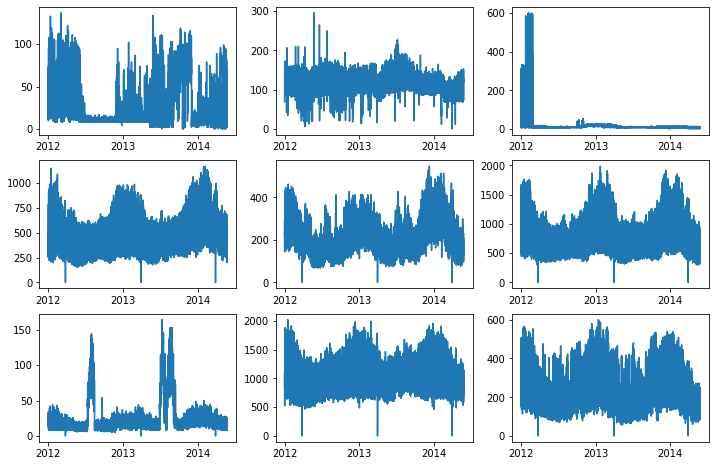

In [5]:
date_formater = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(12,8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx+1)
    t = pd.date_range(start=entry["start"].to_timestamp(), periods=len(entry["target"]), freq=dataset.train.freq)
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

## Probabilistic feed-forward network using PyTorch

We will use a pretty simple model, based on a feed-forward network whose output layer produces the parameters of a parametric distribution. By default, the model will use a Student's t-distribution, but this can be easily customized via the `distr_output` constructor argument.

In [6]:
import torch
import torch.nn as nn

/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator

In [8]:
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [9]:
class FeedForwardNetwork(nn.Module):
    def __init__(
        self,
        freq: str,
        prediction_length: int,
        context_length: int,
        hidden_dimensions: List[int],
        distr_output = StudentTOutput(),
        batch_norm: bool=False,
        scaling: Callable=mean_abs_scaling,
    ) -> None:
        super().__init__()
        
        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dimensions) > 0
        
        self.freq = freq
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dimensions = hidden_dimensions
        self.distr_output = distr_output
        self.batch_norm = batch_norm
        self.scaling = scaling
        
        dimensions = [context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(out_size))
        modules.append(self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1]))
        
        self.nn = nn.Sequential(*modules)
        self.args_proj = self.distr_output.get_args_proj(hidden_dimensions[-1])
        
    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin
    
    def forward(self, context):
        scale = self.scaling(context)
        scaled_context = context / scale
        nn_out = self.nn(scaled_context)
        nn_out_reshaped = nn_out.reshape(-1, self.prediction_length, self.hidden_dimensions[-1])
        distr_args = self.args_proj(nn_out_reshaped)
        return distr_args, torch.zeros_like(scale), scale
    
    def get_predictor(self, input_transform, batch_size=32, device=None):
        return PyTorchPredictor(
            prediction_length=self.prediction_length,
            freq=self.freq, 
            input_names=["past_target"],
            prediction_net=self,
            batch_size=batch_size,
            input_transform=input_transform,
            forecast_generator=DistributionForecastGenerator(self.distr_output),
            device=device,
        )

To train the model using PyTorch Lightning, we only need to extend the class with methods that specify how training steps are supposed to work. Please refer to [documentation for PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) to know more about the interface you need to implement in order to fully customize the training procedure.

In [10]:
import pytorch_lightning as pl

In [11]:
class LightningFeedForwardNetwork(FeedForwardNetwork, pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        context = batch["past_target"]
        target = batch["future_target"]

        assert context.shape[-1] == self.context_length
        assert target.shape[-1] == self.prediction_length

        distr_args, loc, scale = self(context)
        distr = self.distr_output.distribution(distr_args, loc, scale)
        loss = -distr.log_prob(target)

        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

We can now instantiate the training network, and explore its set of parameters.

In [12]:
freq = "1H"
context_length = 2 * 7 * 24
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]

In [13]:
net = LightningFeedForwardNetwork(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=hidden_dimensions,
    distr_output=StudentTOutput(),
)

In [14]:
sum(np.prod(p.shape) for p in net.parameters())

144243

In [15]:
for p in net.parameters():
    print(p.shape)

torch.Size([96, 336])
torch.Size([96])
torch.Size([1152, 96])
torch.Size([1152])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])


## Defining the training data loader

We now set up the data loader which will yield batches of data to train on. Starting from the original dataset, the data loader is configured to apply the following transformation, which does essentially two things:
* Replaces `nan`s in the target field with a dummy value (zero), and adds a field indicating which values were actually observed vs imputed this way.
* Slices out training instances of a fixed length randomly from the given dataset; these will be stacked into batches by the data loader itself.

In [16]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import AddObservedValuesIndicator, InstanceSplitter, ExpectedNumInstanceSampler, TestSplitSampler

In [17]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [18]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [19]:
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify

In [20]:
batch_size = 32
num_batches_per_epoch = 50

In [21]:
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

## Train the model

We can now train the model using the tooling that PyTorch Lightning provides:

In [22]:
trainer = pl.Trainer(max_epochs=10, gpus=-1 if torch.cuda.is_available() else None)
trainer.fit(net, data_loader)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False


INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | nn        | Sequential | 144 K 
1 | args_proj | PtArgProj  | 147   
-----------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.577     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Epoch 0: : 0it [00:00, ?it/s]

Epoch 0: : 1it [00:00,  4.11it/s]

Epoch 0: : 1it [00:00,  4.09it/s, loss=6.71, v_num=36]

Epoch 0: : 2it [00:00,  5.98it/s, loss=6.85, v_num=36]

Epoch 0: : 3it [00:00,  6.60it/s, loss=6.85, v_num=36]

Epoch 0: : 3it [00:00,  6.58it/s, loss=7.11, v_num=36]

Epoch 0: : 4it [00:00,  7.46it/s, loss=7.05, v_num=36]

Epoch 0: : 5it [00:00,  8.34it/s, loss=7.05, v_num=36]

Epoch 0: : 5it [00:00,  8.33it/s, loss=7.26, v_num=36]

Epoch 0: : 6it [00:00,  8.41it/s, loss=7.53, v_num=36]

Epoch 0: : 7it [00:00,  8.70it/s, loss=7.53, v_num=36]

Epoch 0: : 7it [00:00,  8.69it/s, loss=7.47, v_num=36]

Epoch 0: : 8it [00:00,  8.92it/s, loss=7.41, v_num=36]

Epoch 0: : 9it [00:00,  9.10it/s, loss=7.41, v_num=36]

Epoch 0: : 9it [00:00,  9.09it/s, loss=7.39, v_num=36]

Epoch 0: : 10it [00:01,  9.87it/s, loss=7.52, v_num=36]

Epoch 0: : 11it [00:01, 10.68it/s, loss=7.39, v_num=36]

Epoch 0: : 12it [00:01, 11.46it/s, loss=7.26, v_num=36]

Epoch 0: : 13it [00:01, 12.21it/s, loss=7.19, v_num=36]

Epoch 0: : 14it [00:01, 12.96it/s, loss=7.17, v_num=36]

Epoch 0: : 15it [00:01, 13.68it/s, loss=7.17, v_num=36]

Epoch 0: : 15it [00:01, 13.66it/s, loss=7.19, v_num=36]

Epoch 0: : 16it [00:01, 14.35it/s, loss=7.25, v_num=36]

Epoch 0: : 17it [00:01, 15.04it/s, loss=7.24, v_num=36]

Epoch 0: : 18it [00:01, 15.70it/s, loss=7.21, v_num=36]

Epoch 0: : 19it [00:01, 16.32it/s, loss=7.2, v_num=36] 

Epoch 0: : 20it [00:01, 16.94it/s, loss=7.21, v_num=36]

Epoch 0: : 21it [00:01, 17.52it/s, loss=7.21, v_num=36]

Epoch 0: : 21it [00:01, 17.50it/s, loss=7.18, v_num=36]

Epoch 0: : 22it [00:01, 18.05it/s, loss=7.11, v_num=36]

Epoch 0: : 23it [00:01, 18.60it/s, loss=7.05, v_num=36]

Epoch 0: : 24it [00:01, 19.17it/s, loss=7.07, v_num=36]

Epoch 0: : 25it [00:01, 19.70it/s, loss=6.99, v_num=36]

Epoch 0: : 26it [00:01, 20.20it/s, loss=6.94, v_num=36]

Epoch 0: : 27it [00:01, 20.73it/s, loss=6.94, v_num=36]

Epoch 0: : 27it [00:01, 20.71it/s, loss=6.93, v_num=36]

Epoch 0: : 28it [00:01, 21.23it/s, loss=6.9, v_num=36] 

Epoch 0: : 29it [00:01, 21.74it/s, loss=6.85, v_num=36]

Epoch 0: : 30it [00:01, 22.18it/s, loss=6.77, v_num=36]

Epoch 0: : 31it [00:01, 22.61it/s, loss=6.82, v_num=36]

Epoch 0: : 32it [00:01, 23.04it/s, loss=6.8, v_num=36] 

Epoch 0: : 33it [00:01, 23.46it/s, loss=6.8, v_num=36]

Epoch 0: : 33it [00:01, 23.44it/s, loss=6.76, v_num=36]

Epoch 0: : 34it [00:01, 23.84it/s, loss=6.76, v_num=36]

Epoch 0: : 35it [00:01, 24.26it/s, loss=6.72, v_num=36]

Epoch 0: : 36it [00:01, 24.66it/s, loss=6.65, v_num=36]

Epoch 0: : 37it [00:01, 25.06it/s, loss=6.63, v_num=36]

Epoch 0: : 38it [00:01, 25.45it/s, loss=6.6, v_num=36] 

Epoch 0: : 39it [00:01, 25.80it/s, loss=6.6, v_num=36]

Epoch 0: : 39it [00:01, 25.78it/s, loss=6.57, v_num=36]

Epoch 0: : 40it [00:01, 26.12it/s, loss=6.49, v_num=36]

Epoch 0: : 41it [00:01, 26.49it/s, loss=6.49, v_num=36]

Epoch 0: : 42it [00:01, 26.81it/s, loss=6.5, v_num=36] 

Epoch 0: : 43it [00:01, 27.15it/s, loss=6.49, v_num=36]

Epoch 0: : 44it [00:01, 27.47it/s, loss=6.45, v_num=36]

Epoch 0: : 45it [00:01, 27.81it/s, loss=6.45, v_num=36]

Epoch 0: : 45it [00:01, 27.79it/s, loss=6.48, v_num=36]

Epoch 0: : 46it [00:01, 28.09it/s, loss=6.45, v_num=36]

Epoch 0: : 47it [00:01, 28.41it/s, loss=6.39, v_num=36]

Epoch 0: : 48it [00:01, 28.71it/s, loss=6.41, v_num=36]

Epoch 0: : 49it [00:01, 29.04it/s, loss=6.41, v_num=36]

Epoch 0: : 50it [00:01, 29.49it/s, loss=6.4, v_num=36] 

Epoch 0: : 51it [00:01, 30.06it/s, loss=6.4, v_num=36]

Epoch 0: : 0it [00:00, ?it/s, loss=6.4, v_num=36]     

Epoch 1: : 0it [00:00, ?it/s, loss=6.4, v_num=36]

Epoch 1: : 1it [00:00, 34.34it/s, loss=6.33, v_num=36]

Epoch 1: : 2it [00:00, 44.08it/s, loss=6.32, v_num=36]

Epoch 1: : 3it [00:00, 48.34it/s, loss=6.37, v_num=36]

Epoch 1: : 4it [00:00, 50.74it/s, loss=6.35, v_num=36]

Epoch 1: : 5it [00:00, 52.22it/s, loss=6.33, v_num=36]

Epoch 1: : 6it [00:00, 52.85it/s, loss=6.33, v_num=36]

Epoch 1: : 6it [00:00, 52.41it/s, loss=6.35, v_num=36]

Epoch 1: : 7it [00:00, 52.83it/s, loss=6.35, v_num=36]

Epoch 1: : 8it [00:00, 54.29it/s, loss=6.34, v_num=36]

Epoch 1: : 9it [00:00, 55.91it/s, loss=6.36, v_num=36]

Epoch 1: : 10it [00:00, 57.19it/s, loss=6.4, v_num=36]

Epoch 1: : 11it [00:00, 57.69it/s, loss=6.36, v_num=36]

Epoch 1: : 12it [00:00, 58.73it/s, loss=6.34, v_num=36]

Epoch 1: : 13it [00:00, 59.56it/s, loss=6.34, v_num=36]

Epoch 1: : 13it [00:00, 59.36it/s, loss=6.33, v_num=36]

Epoch 1: : 14it [00:00, 59.95it/s, loss=6.33, v_num=36]

Epoch 1: : 15it [00:00, 60.33it/s, loss=6.3, v_num=36] 

Epoch 1: : 16it [00:00, 61.59it/s, loss=6.3, v_num=36]

Epoch 1: : 17it [00:00, 61.21it/s, loss=6.33, v_num=36]

Epoch 1: : 18it [00:00, 61.55it/s, loss=6.33, v_num=36]

Epoch 1: : 19it [00:00, 61.32it/s, loss=6.31, v_num=36]

Epoch 1: : 20it [00:00, 61.43it/s, loss=6.31, v_num=36]

Epoch 1: : 20it [00:00, 61.21it/s, loss=6.36, v_num=36]

Epoch 1: : 21it [00:00, 61.06it/s, loss=6.36, v_num=36]

Epoch 1: : 22it [00:00, 61.18it/s, loss=6.35, v_num=36]

Epoch 1: : 23it [00:00, 60.83it/s, loss=6.31, v_num=36]

Epoch 1: : 24it [00:00, 60.70it/s, loss=6.31, v_num=36]

Epoch 1: : 25it [00:00, 60.84it/s, loss=6.28, v_num=36]

Epoch 1: : 26it [00:00, 60.63it/s, loss=6.3, v_num=36] 

Epoch 1: : 27it [00:00, 60.40it/s, loss=6.3, v_num=36]

Epoch 1: : 27it [00:00, 60.27it/s, loss=6.28, v_num=36]

Epoch 1: : 28it [00:00, 60.20it/s, loss=6.28, v_num=36]

Epoch 1: : 29it [00:00, 59.89it/s, loss=6.25, v_num=36]

Epoch 1: : 30it [00:00, 60.07it/s, loss=6.26, v_num=36]

Epoch 1: : 31it [00:00, 59.98it/s, loss=6.26, v_num=36]

Epoch 1: : 32it [00:00, 59.83it/s, loss=6.25, v_num=36]

Epoch 1: : 33it [00:00, 59.86it/s, loss=6.28, v_num=36]

Epoch 1: : 34it [00:00, 60.07it/s, loss=6.28, v_num=36]

Epoch 1: : 34it [00:00, 59.97it/s, loss=6.25, v_num=36]

Epoch 1: : 35it [00:00, 60.17it/s, loss=6.27, v_num=36]

Epoch 1: : 36it [00:00, 60.04it/s, loss=6.26, v_num=36]

Epoch 1: : 37it [00:00, 60.10it/s, loss=6.24, v_num=36]

Epoch 1: : 38it [00:00, 60.50it/s, loss=6.23, v_num=36]

Epoch 1: : 39it [00:00, 60.87it/s, loss=6.27, v_num=36]

Epoch 1: : 40it [00:00, 60.97it/s, loss=6.18, v_num=36]

Epoch 1: : 41it [00:00, 60.96it/s, loss=6.18, v_num=36]

Epoch 1: : 41it [00:00, 60.87it/s, loss=6.15, v_num=36]

Epoch 1: : 42it [00:00, 60.88it/s, loss=6.17, v_num=36]

Epoch 1: : 43it [00:00, 60.80it/s, loss=6.23, v_num=36]

Epoch 1: : 44it [00:00, 60.89it/s, loss=6.23, v_num=36]

Epoch 1: : 45it [00:00, 61.00it/s, loss=6.25, v_num=36]

Epoch 1: : 46it [00:00, 61.18it/s, loss=6.25, v_num=36]

Epoch 1: : 47it [00:00, 61.11it/s, loss=6.24, v_num=36]

Epoch 1: : 48it [00:00, 60.96it/s, loss=6.24, v_num=36]

Epoch 1: : 48it [00:00, 60.88it/s, loss=6.26, v_num=36]

Epoch 1: : 49it [00:00, 60.90it/s, loss=6.26, v_num=36]

Epoch 1: : 50it [00:00, 61.59it/s, loss=6.23, v_num=36]

Epoch 1: : 51it [00:00, 62.61it/s, loss=6.23, v_num=36]

Epoch 1: : 0it [00:00, ?it/s, loss=6.23, v_num=36]     

Epoch 2: : 0it [00:00, ?it/s, loss=6.23, v_num=36]

Epoch 2: : 1it [00:00, 39.39it/s, loss=6.26, v_num=36]

Epoch 2: : 2it [00:00, 47.39it/s, loss=6.26, v_num=36]

Epoch 2: : 3it [00:00, 52.12it/s, loss=6.18, v_num=36]

Epoch 2: : 4it [00:00, 54.76it/s, loss=6.23, v_num=36]

Epoch 2: : 5it [00:00, 55.86it/s, loss=6.17, v_num=36]

Epoch 2: : 6it [00:00, 57.67it/s, loss=6.15, v_num=36]

Epoch 2: : 7it [00:00, 58.36it/s, loss=6.15, v_num=36]

Epoch 2: : 7it [00:00, 57.87it/s, loss=6.1, v_num=36] 

Epoch 2: : 8it [00:00, 58.24it/s, loss=6.1, v_num=36]

Epoch 2: : 9it [00:00, 58.51it/s, loss=6.07, v_num=36]

Epoch 2: : 10it [00:00, 59.28it/s, loss=6.07, v_num=36]

Epoch 2: : 11it [00:00, 59.17it/s, loss=6.19, v_num=36]

Epoch 2: : 12it [00:00, 59.27it/s, loss=6.17, v_num=36]

Epoch 2: : 13it [00:00, 59.28it/s, loss=6.1, v_num=36] 

Epoch 2: : 14it [00:00, 59.39it/s, loss=6.1, v_num=36]

Epoch 2: : 14it [00:00, 59.14it/s, loss=6.1, v_num=36]

Epoch 2: : 15it [00:00, 58.72it/s, loss=6.09, v_num=36]

Epoch 2: : 16it [00:00, 58.79it/s, loss=6.05, v_num=36]

Epoch 2: : 17it [00:00, 58.73it/s, loss=6.06, v_num=36]

Epoch 2: : 18it [00:00, 58.35it/s, loss=6.05, v_num=36]

Epoch 2: : 19it [00:00, 58.50it/s, loss=6.07, v_num=36]

Epoch 2: : 20it [00:00, 58.67it/s, loss=6.06, v_num=36]

Epoch 2: : 21it [00:00, 58.74it/s, loss=6.06, v_num=36]

Epoch 2: : 21it [00:00, 58.57it/s, loss=6.1, v_num=36] 

Epoch 2: : 22it [00:00, 58.88it/s, loss=6.11, v_num=36]

Epoch 2: : 23it [00:00, 58.73it/s, loss=6.13, v_num=36]

Epoch 2: : 24it [00:00, 58.90it/s, loss=6.11, v_num=36]

Epoch 2: : 25it [00:00, 58.88it/s, loss=6.12, v_num=36]

Epoch 2: : 26it [00:00, 59.19it/s, loss=6.13, v_num=36]

Epoch 2: : 27it [00:00, 59.37it/s, loss=6.21, v_num=36]

Epoch 2: : 28it [00:00, 59.38it/s, loss=6.21, v_num=36]

Epoch 2: : 28it [00:00, 59.25it/s, loss=6.22, v_num=36]

Epoch 2: : 29it [00:00, 59.42it/s, loss=6.2, v_num=36] 

Epoch 2: : 30it [00:00, 59.42it/s, loss=6.22, v_num=36]

Epoch 2: : 31it [00:00, 59.61it/s, loss=6.2, v_num=36] 

Epoch 2: : 32it [00:00, 59.46it/s, loss=6.2, v_num=36]

Epoch 2: : 33it [00:00, 59.35it/s, loss=6.19, v_num=36]

Epoch 2: : 34it [00:00, 59.55it/s, loss=6.2, v_num=36] 

Epoch 2: : 35it [00:00, 59.60it/s, loss=6.2, v_num=36]

Epoch 2: : 35it [00:00, 59.49it/s, loss=6.17, v_num=36]

Epoch 2: : 36it [00:00, 59.32it/s, loss=6.15, v_num=36]

Epoch 2: : 37it [00:00, 59.15it/s, loss=6.16, v_num=36]

Epoch 2: : 38it [00:00, 58.89it/s, loss=6.14, v_num=36]

Epoch 2: : 39it [00:00, 58.72it/s, loss=6.13, v_num=36]

Epoch 2: : 40it [00:00, 58.58it/s, loss=6.14, v_num=36]

Epoch 2: : 41it [00:00, 58.46it/s, loss=6.19, v_num=36]

Epoch 2: : 42it [00:00, 58.30it/s, loss=6.19, v_num=36]

Epoch 2: : 42it [00:00, 58.22it/s, loss=6.17, v_num=36]

Epoch 2: : 43it [00:00, 58.35it/s, loss=6.17, v_num=36]

Epoch 2: : 44it [00:00, 57.96it/s, loss=6.14, v_num=36]

Epoch 2: : 45it [00:00, 57.81it/s, loss=6.18, v_num=36]

Epoch 2: : 46it [00:00, 57.62it/s, loss=6.17, v_num=36]

Epoch 2: : 47it [00:00, 57.67it/s, loss=6.15, v_num=36]

Epoch 2: : 48it [00:00, 57.53it/s, loss=6.14, v_num=36]

Epoch 2: : 49it [00:00, 57.44it/s, loss=6.14, v_num=36]

Epoch 2: : 49it [00:00, 57.37it/s, loss=6.14, v_num=36]

Epoch 2: : 50it [00:00, 58.00it/s, loss=6.16, v_num=36]

Epoch 2: : 51it [00:00, 59.05it/s, loss=6.16, v_num=36]

Epoch 2: : 0it [00:00, ?it/s, loss=6.16, v_num=36]     

Epoch 3: : 0it [00:00, ?it/s, loss=6.16, v_num=36]

Epoch 3: : 1it [00:00, 38.85it/s, loss=6.06, v_num=36]

Epoch 3: : 2it [00:00, 45.76it/s, loss=6.08, v_num=36]

Epoch 3: : 3it [00:00, 48.61it/s, loss=6.1, v_num=36] 

Epoch 3: : 4it [00:00, 49.47it/s, loss=6.08, v_num=36]

Epoch 3: : 5it [00:00, 49.83it/s, loss=6.11, v_num=36]

Epoch 3: : 6it [00:00, 50.85it/s, loss=6.12, v_num=36]

Epoch 3: : 7it [00:00, 51.09it/s, loss=6.12, v_num=36]

Epoch 3: : 7it [00:00, 50.63it/s, loss=6.09, v_num=36]

Epoch 3: : 8it [00:00, 50.50it/s, loss=6.1, v_num=36] 

Epoch 3: : 9it [00:00, 49.99it/s, loss=6.12, v_num=36]

Epoch 3: : 10it [00:00, 49.79it/s, loss=6.15, v_num=36]

Epoch 3: : 11it [00:00, 50.17it/s, loss=6.02, v_num=36]

Epoch 3: : 12it [00:00, 50.86it/s, loss=6.03, v_num=36]

Epoch 3: : 13it [00:00, 51.70it/s, loss=6.07, v_num=36]

Epoch 3: : 14it [00:00, 52.15it/s, loss=6.07, v_num=36]

Epoch 3: : 14it [00:00, 51.93it/s, loss=6.08, v_num=36]

Epoch 3: : 15it [00:00, 52.00it/s, loss=6.1, v_num=36] 

Epoch 3: : 16it [00:00, 52.69it/s, loss=6.06, v_num=36]

Epoch 3: : 17it [00:00, 53.33it/s, loss=6.05, v_num=36]

Epoch 3: : 18it [00:00, 53.70it/s, loss=6.04, v_num=36]

Epoch 3: : 19it [00:00, 54.37it/s, loss=6.05, v_num=36]

Epoch 3: : 20it [00:00, 54.81it/s, loss=6.05, v_num=36]

Epoch 3: : 21it [00:00, 55.16it/s, loss=6.05, v_num=36]

Epoch 3: : 21it [00:00, 55.03it/s, loss=6.03, v_num=36]

Epoch 3: : 22it [00:00, 55.42it/s, loss=6.04, v_num=36]

Epoch 3: : 23it [00:00, 55.56it/s, loss=6.04, v_num=36]

Epoch 3: : 24it [00:00, 55.68it/s, loss=6.05, v_num=36]

Epoch 3: : 25it [00:00, 55.89it/s, loss=6.04, v_num=36]

Epoch 3: : 26it [00:00, 56.26it/s, loss=6.04, v_num=36]

Epoch 3: : 27it [00:00, 56.31it/s, loss=6.06, v_num=36]

Epoch 3: : 28it [00:00, 56.43it/s, loss=6.06, v_num=36]

Epoch 3: : 28it [00:00, 56.32it/s, loss=6.06, v_num=36]

Epoch 3: : 29it [00:00, 56.40it/s, loss=6.04, v_num=36]

Epoch 3: : 30it [00:00, 56.43it/s, loss=6.03, v_num=36]

Epoch 3: : 31it [00:00, 56.52it/s, loss=6.07, v_num=36]

Epoch 3: : 32it [00:00, 56.70it/s, loss=6.08, v_num=36]

Epoch 3: : 33it [00:00, 56.93it/s, loss=6.03, v_num=36]

Epoch 3: : 34it [00:00, 57.09it/s, loss=6.05, v_num=36]

Epoch 3: : 35it [00:00, 57.48it/s, loss=6.05, v_num=36]

Epoch 3: : 35it [00:00, 57.39it/s, loss=6, v_num=36]   

Epoch 3: : 36it [00:00, 57.50it/s, loss=6.01, v_num=36]

Epoch 3: : 37it [00:00, 57.66it/s, loss=6.04, v_num=36]

Epoch 3: : 38it [00:00, 57.85it/s, loss=6.05, v_num=36]

Epoch 3: : 39it [00:00, 58.16it/s, loss=6.05, v_num=36]

Epoch 3: : 40it [00:00, 58.37it/s, loss=6.01, v_num=36]

Epoch 3: : 41it [00:00, 58.60it/s, loss=6.12, v_num=36]

Epoch 3: : 42it [00:00, 58.69it/s, loss=6.12, v_num=36]

Epoch 3: : 42it [00:00, 58.61it/s, loss=6.1, v_num=36] 

Epoch 3: : 43it [00:00, 58.74it/s, loss=6.07, v_num=36]

Epoch 3: : 44it [00:00, 58.79it/s, loss=6.02, v_num=36]

Epoch 3: : 45it [00:00, 59.01it/s, loss=6.02, v_num=36]

Epoch 3: : 46it [00:00, 59.07it/s, loss=5.99, v_num=36]

Epoch 3: : 47it [00:00, 59.21it/s, loss=6.02, v_num=36]

Epoch 3: : 48it [00:00, 59.40it/s, loss=6.02, v_num=36]

Epoch 3: : 49it [00:00, 59.55it/s, loss=6.02, v_num=36]

Epoch 3: : 49it [00:00, 59.49it/s, loss=6.01, v_num=36]

Epoch 3: : 50it [00:00, 60.29it/s, loss=5.98, v_num=36]

Epoch 3: : 51it [00:00, 61.40it/s, loss=5.98, v_num=36]

Epoch 3: : 0it [00:00, ?it/s, loss=5.98, v_num=36]     

Epoch 4: : 0it [00:00, ?it/s, loss=5.98, v_num=36]

Epoch 4: : 1it [00:00, 39.49it/s, loss=5.99, v_num=36]

Epoch 4: : 2it [00:00, 47.99it/s, loss=6.04, v_num=36]

Epoch 4: : 3it [00:00, 54.31it/s, loss=6.03, v_num=36]

Epoch 4: : 4it [00:00, 56.07it/s, loss=5.98, v_num=36]

Epoch 4: : 5it [00:00, 59.51it/s, loss=6.01, v_num=36]

Epoch 4: : 6it [00:00, 60.16it/s, loss=6.01, v_num=36]

Epoch 4: : 7it [00:00, 60.50it/s, loss=6.01, v_num=36]

Epoch 4: : 7it [00:00, 60.08it/s, loss=6, v_num=36]   

Epoch 4: : 8it [00:00, 61.53it/s, loss=5.99, v_num=36]

Epoch 4: : 9it [00:00, 63.15it/s, loss=5.96, v_num=36]

Epoch 4: : 10it [00:00, 64.35it/s, loss=5.97, v_num=36]

Epoch 4: : 11it [00:00, 64.35it/s, loss=5.97, v_num=36]

Epoch 4: : 12it [00:00, 64.53it/s, loss=5.94, v_num=36]

Epoch 4: : 13it [00:00, 66.09it/s, loss=5.93, v_num=36]

Epoch 4: : 14it [00:00, 64.94it/s, loss=5.95, v_num=36]

Epoch 4: : 15it [00:00, 64.31it/s, loss=5.95, v_num=36]

Epoch 4: : 15it [00:00, 64.04it/s, loss=5.94, v_num=36]

Epoch 4: : 16it [00:00, 63.33it/s, loss=5.95, v_num=36]

Epoch 4: : 17it [00:00, 63.01it/s, loss=5.98, v_num=36]

Epoch 4: : 18it [00:00, 63.27it/s, loss=5.97, v_num=36]

Epoch 4: : 19it [00:00, 60.65it/s, loss=5.98, v_num=36]

Epoch 4: : 20it [00:00, 50.55it/s, loss=5.96, v_num=36]

Epoch 4: : 21it [00:00, 50.23it/s, loss=5.96, v_num=36]

Epoch 4: : 22it [00:00, 50.24it/s, loss=5.92, v_num=36]

Epoch 4: : 23it [00:00, 50.11it/s, loss=5.92, v_num=36]

Epoch 4: : 23it [00:00, 50.01it/s, loss=5.93, v_num=36]

Epoch 4: : 24it [00:00, 50.17it/s, loss=5.92, v_num=36]

Epoch 4: : 25it [00:00, 50.32it/s, loss=5.92, v_num=36]

Epoch 4: : 26it [00:00, 50.66it/s, loss=5.93, v_num=36]

Epoch 4: : 27it [00:00, 51.11it/s, loss=5.94, v_num=36]

Epoch 4: : 28it [00:00, 51.41it/s, loss=5.93, v_num=36]

Epoch 4: : 29it [00:00, 51.81it/s, loss=5.95, v_num=36]

Epoch 4: : 30it [00:00, 52.07it/s, loss=5.95, v_num=36]

Epoch 4: : 31it [00:00, 52.44it/s, loss=5.95, v_num=36]

Epoch 4: : 31it [00:00, 52.35it/s, loss=5.91, v_num=36]

Epoch 4: : 32it [00:00, 52.37it/s, loss=5.91, v_num=36]

Epoch 4: : 33it [00:00, 52.90it/s, loss=5.93, v_num=36]

Epoch 4: : 34it [00:00, 53.05it/s, loss=5.96, v_num=36]

Epoch 4: : 35it [00:00, 53.42it/s, loss=5.94, v_num=36]

Epoch 4: : 36it [00:00, 53.62it/s, loss=5.97, v_num=36]

Epoch 4: : 37it [00:00, 54.06it/s, loss=5.96, v_num=36]

Epoch 4: : 38it [00:00, 54.42it/s, loss=5.96, v_num=36]

Epoch 4: : 39it [00:00, 54.66it/s, loss=5.96, v_num=36]

Epoch 4: : 39it [00:00, 54.59it/s, loss=5.97, v_num=36]

Epoch 4: : 40it [00:00, 55.00it/s, loss=5.98, v_num=36]

Epoch 4: : 41it [00:00, 55.44it/s, loss=6, v_num=36]   

Epoch 4: : 42it [00:00, 55.81it/s, loss=5.99, v_num=36]

Epoch 4: : 43it [00:00, 56.18it/s, loss=5.99, v_num=36]

Epoch 4: : 44it [00:00, 56.57it/s, loss=6.05, v_num=36]

Epoch 4: : 45it [00:00, 56.90it/s, loss=6.06, v_num=36]

Epoch 4: : 46it [00:00, 56.95it/s, loss=6.07, v_num=36]

Epoch 4: : 47it [00:00, 57.02it/s, loss=6.07, v_num=36]

Epoch 4: : 47it [00:00, 56.97it/s, loss=6.03, v_num=36]

Epoch 4: : 48it [00:00, 57.13it/s, loss=6.04, v_num=36]

Epoch 4: : 49it [00:00, 57.21it/s, loss=6.04, v_num=36]

Epoch 4: : 50it [00:00, 57.93it/s, loss=6.06, v_num=36]

Epoch 4: : 51it [00:00, 59.00it/s, loss=6.06, v_num=36]

Epoch 4: : 0it [00:00, ?it/s, loss=6.06, v_num=36]     

Epoch 5: : 0it [00:00, ?it/s, loss=6.06, v_num=36]

Epoch 5: : 1it [00:00, 38.32it/s, loss=6.03, v_num=36]

Epoch 5: : 2it [00:00, 46.45it/s, loss=6.06, v_num=36]

Epoch 5: : 3it [00:00, 53.54it/s, loss=6.08, v_num=36]

Epoch 5: : 4it [00:00, 55.57it/s, loss=6.09, v_num=36]

Epoch 5: : 5it [00:00, 56.80it/s, loss=6.12, v_num=36]

Epoch 5: : 6it [00:00, 58.05it/s, loss=6.16, v_num=36]

Epoch 5: : 7it [00:00, 58.89it/s, loss=6.15, v_num=36]

Epoch 5: : 8it [00:00, 61.01it/s, loss=6.15, v_num=36]

Epoch 5: : 8it [00:00, 60.66it/s, loss=6.15, v_num=36]

Epoch 5: : 9it [00:00, 61.81it/s, loss=6.14, v_num=36]

Epoch 5: : 10it [00:00, 62.29it/s, loss=6.14, v_num=36]

Epoch 5: : 11it [00:00, 63.62it/s, loss=6.11, v_num=36]

Epoch 5: : 12it [00:00, 64.04it/s, loss=6.08, v_num=36]

Epoch 5: : 13it [00:00, 65.22it/s, loss=6.07, v_num=36]

Epoch 5: : 14it [00:00, 66.43it/s, loss=6.06, v_num=36]

Epoch 5: : 15it [00:00, 67.43it/s, loss=6.04, v_num=36]

Epoch 5: : 16it [00:00, 67.60it/s, loss=6.04, v_num=36]

Epoch 5: : 16it [00:00, 67.37it/s, loss=6.03, v_num=36]

Epoch 5: : 17it [00:00, 68.00it/s, loss=6.04, v_num=36]

Epoch 5: : 18it [00:00, 67.98it/s, loss=6.03, v_num=36]

Epoch 5: : 19it [00:00, 68.28it/s, loss=6.03, v_num=36]

Epoch 5: : 20it [00:00, 68.26it/s, loss=6.02, v_num=36]

Epoch 5: : 21it [00:00, 67.58it/s, loss=6.04, v_num=36]

Epoch 5: : 22it [00:00, 67.37it/s, loss=6.04, v_num=36]

Epoch 5: : 23it [00:00, 67.12it/s, loss=6.02, v_num=36]

Epoch 5: : 24it [00:00, 67.28it/s, loss=6.02, v_num=36]

Epoch 5: : 24it [00:00, 67.10it/s, loss=6, v_num=36]   

Epoch 5: : 25it [00:00, 67.00it/s, loss=5.98, v_num=36]

Epoch 5: : 26it [00:00, 67.25it/s, loss=5.93, v_num=36]

Epoch 5: : 27it [00:00, 67.45it/s, loss=5.85, v_num=36]

Epoch 5: : 28it [00:00, 68.15it/s, loss=5.87, v_num=36]

Epoch 5: : 29it [00:00, 68.29it/s, loss=5.86, v_num=36]

Epoch 5: : 30it [00:00, 68.51it/s, loss=5.85, v_num=36]

Epoch 5: : 31it [00:00, 68.68it/s, loss=5.89, v_num=36]

Epoch 5: : 32it [00:00, 69.06it/s, loss=5.89, v_num=36]

Epoch 5: : 32it [00:00, 68.95it/s, loss=5.98, v_num=36]

Epoch 5: : 33it [00:00, 69.38it/s, loss=5.98, v_num=36]

Epoch 5: : 34it [00:00, 69.53it/s, loss=5.94, v_num=36]

Epoch 5: : 35it [00:00, 69.31it/s, loss=5.9, v_num=36] 

Epoch 5: : 36it [00:00, 68.93it/s, loss=5.91, v_num=36]

Epoch 5: : 37it [00:00, 69.07it/s, loss=5.92, v_num=36]

Epoch 5: : 38it [00:00, 68.95it/s, loss=5.97, v_num=36]

Epoch 5: : 39it [00:00, 68.71it/s, loss=6.01, v_num=36]

Epoch 5: : 40it [00:00, 69.03it/s, loss=6.01, v_num=36]

Epoch 5: : 40it [00:00, 68.93it/s, loss=5.98, v_num=36]

Epoch 5: : 41it [00:00, 68.88it/s, loss=5.97, v_num=36]

Epoch 5: : 42it [00:00, 68.77it/s, loss=6.01, v_num=36]

Epoch 5: : 43it [00:00, 68.89it/s, loss=6.04, v_num=36]

Epoch 5: : 44it [00:00, 68.98it/s, loss=6.01, v_num=36]

Epoch 5: : 45it [00:00, 69.33it/s, loss=5.97, v_num=36]

Epoch 5: : 46it [00:00, 69.58it/s, loss=5.95, v_num=36]

Epoch 5: : 47it [00:00, 69.80it/s, loss=5.98, v_num=36]

Epoch 5: : 48it [00:00, 69.89it/s, loss=5.98, v_num=36]

Epoch 5: : 48it [00:00, 69.81it/s, loss=6.02, v_num=36]

Epoch 5: : 49it [00:00, 69.76it/s, loss=6, v_num=36]   

Epoch 5: : 50it [00:00, 70.59it/s, loss=5.99, v_num=36]

Epoch 5: : 51it [00:00, 71.84it/s, loss=5.99, v_num=36]

Epoch 5: : 0it [00:00, ?it/s, loss=5.99, v_num=36]     

Epoch 6: : 0it [00:00, ?it/s, loss=5.99, v_num=36]

Epoch 6: : 1it [00:00, 38.92it/s, loss=5.96, v_num=36]

Epoch 6: : 2it [00:00, 45.77it/s, loss=5.97, v_num=36]

Epoch 6: : 3it [00:00, 49.33it/s, loss=5.97, v_num=36]

Epoch 6: : 4it [00:00, 51.09it/s, loss=5.95, v_num=36]

Epoch 6: : 5it [00:00, 52.94it/s, loss=6, v_num=36]   

Epoch 6: : 6it [00:00, 54.95it/s, loss=5.95, v_num=36]

Epoch 6: : 7it [00:00, 56.83it/s, loss=5.91, v_num=36]

Epoch 6: : 8it [00:00, 56.80it/s, loss=5.91, v_num=36]

Epoch 6: : 8it [00:00, 56.43it/s, loss=5.9, v_num=36] 

Epoch 6: : 9it [00:00, 57.77it/s, loss=5.85, v_num=36]

Epoch 6: : 10it [00:00, 57.83it/s, loss=5.84, v_num=36]

Epoch 6: : 11it [00:00, 58.32it/s, loss=5.85, v_num=36]

Epoch 6: : 12it [00:00, 58.91it/s, loss=5.86, v_num=36]

Epoch 6: : 13it [00:00, 59.73it/s, loss=5.83, v_num=36]

Epoch 6: : 14it [00:00, 60.93it/s, loss=5.84, v_num=36]

Epoch 6: : 15it [00:00, 61.80it/s, loss=5.82, v_num=36]

Epoch 6: : 16it [00:00, 62.52it/s, loss=5.82, v_num=36]

Epoch 6: : 16it [00:00, 62.33it/s, loss=5.84, v_num=36]

Epoch 6: : 17it [00:00, 62.57it/s, loss=5.83, v_num=36]

Epoch 6: : 18it [00:00, 62.55it/s, loss=5.74, v_num=36]

Epoch 6: : 19it [00:00, 62.61it/s, loss=5.76, v_num=36]

Epoch 6: : 20it [00:00, 62.86it/s, loss=5.78, v_num=36]

Epoch 6: : 21it [00:00, 62.43it/s, loss=5.78, v_num=36]

Epoch 6: : 22it [00:00, 62.56it/s, loss=5.76, v_num=36]

Epoch 6: : 23it [00:00, 62.09it/s, loss=5.78, v_num=36]

Epoch 6: : 24it [00:00, 62.36it/s, loss=5.78, v_num=36]

Epoch 6: : 24it [00:00, 62.21it/s, loss=5.78, v_num=36]

Epoch 6: : 25it [00:00, 61.98it/s, loss=5.78, v_num=36]

Epoch 6: : 26it [00:00, 61.87it/s, loss=5.81, v_num=36]

Epoch 6: : 27it [00:00, 62.03it/s, loss=5.83, v_num=36]

Epoch 6: : 28it [00:00, 61.65it/s, loss=5.78, v_num=36]

Epoch 6: : 29it [00:00, 61.67it/s, loss=5.8, v_num=36] 

Epoch 6: : 30it [00:00, 61.89it/s, loss=5.81, v_num=36]

Epoch 6: : 31it [00:00, 62.45it/s, loss=5.85, v_num=36]

Epoch 6: : 32it [00:00, 62.87it/s, loss=5.85, v_num=36]

Epoch 6: : 32it [00:00, 62.78it/s, loss=5.83, v_num=36]

Epoch 6: : 33it [00:00, 63.25it/s, loss=5.83, v_num=36]

Epoch 6: : 34it [00:00, 63.75it/s, loss=5.82, v_num=36]

Epoch 6: : 35it [00:00, 63.96it/s, loss=5.88, v_num=36]

Epoch 6: : 36it [00:00, 64.31it/s, loss=5.89, v_num=36]

Epoch 6: : 37it [00:00, 64.61it/s, loss=5.92, v_num=36]

Epoch 6: : 38it [00:00, 64.98it/s, loss=5.95, v_num=36]

Epoch 6: : 39it [00:00, 65.33it/s, loss=5.95, v_num=36]

Epoch 6: : 40it [00:00, 65.65it/s, loss=5.95, v_num=36]

Epoch 6: : 40it [00:00, 65.56it/s, loss=5.94, v_num=36]

Epoch 6: : 41it [00:00, 65.80it/s, loss=5.98, v_num=36]

Epoch 6: : 42it [00:00, 66.10it/s, loss=5.94, v_num=36]

Epoch 6: : 43it [00:00, 66.28it/s, loss=5.94, v_num=36]

Epoch 6: : 44it [00:00, 66.57it/s, loss=5.94, v_num=36]

Epoch 6: : 45it [00:00, 66.87it/s, loss=5.95, v_num=36]

Epoch 6: : 46it [00:00, 66.81it/s, loss=5.95, v_num=36]

Epoch 6: : 47it [00:00, 66.76it/s, loss=5.97, v_num=36]

Epoch 6: : 48it [00:00, 66.77it/s, loss=5.97, v_num=36]

Epoch 6: : 48it [00:00, 66.69it/s, loss=5.97, v_num=36]

Epoch 6: : 49it [00:00, 66.50it/s, loss=5.96, v_num=36]

Epoch 6: : 50it [00:00, 67.31it/s, loss=5.97, v_num=36]

Epoch 6: : 51it [00:00, 68.56it/s, loss=5.97, v_num=36]

Epoch 6: : 0it [00:00, ?it/s, loss=5.97, v_num=36]     

Epoch 7: : 0it [00:00, ?it/s, loss=5.97, v_num=36]

Epoch 7: : 1it [00:00, 53.08it/s, loss=5.96, v_num=36]

Epoch 7: : 2it [00:00, 65.63it/s, loss=5.94, v_num=36]

Epoch 7: : 3it [00:00, 69.82it/s, loss=5.95, v_num=36]

Epoch 7: : 4it [00:00, 70.69it/s, loss=5.94, v_num=36]

Epoch 7: : 5it [00:00, 70.01it/s, loss=5.95, v_num=36]

Epoch 7: : 6it [00:00, 71.93it/s, loss=5.95, v_num=36]

Epoch 7: : 7it [00:00, 71.17it/s, loss=5.96, v_num=36]

Epoch 7: : 8it [00:00, 70.63it/s, loss=5.96, v_num=36]

Epoch 7: : 8it [00:00, 70.15it/s, loss=5.99, v_num=36]

Epoch 7: : 9it [00:00, 70.41it/s, loss=6, v_num=36]   

Epoch 7: : 10it [00:00, 70.75it/s, loss=6, v_num=36]

Epoch 7: : 11it [00:00, 70.78it/s, loss=6.01, v_num=36]

Epoch 7: : 12it [00:00, 71.68it/s, loss=5.97, v_num=36]

Epoch 7: : 13it [00:00, 72.17it/s, loss=5.93, v_num=36]

Epoch 7: : 14it [00:00, 72.24it/s, loss=5.96, v_num=36]

Epoch 7: : 15it [00:00, 72.40it/s, loss=5.94, v_num=36]

Epoch 7: : 16it [00:00, 72.71it/s, loss=5.94, v_num=36]

Epoch 7: : 16it [00:00, 72.47it/s, loss=5.94, v_num=36]

Epoch 7: : 17it [00:00, 73.07it/s, loss=5.81, v_num=36]

Epoch 7: : 18it [00:00, 72.85it/s, loss=5.82, v_num=36]

Epoch 7: : 19it [00:00, 73.55it/s, loss=5.82, v_num=36]

Epoch 7: : 20it [00:00, 74.19it/s, loss=5.84, v_num=36]

Epoch 7: : 21it [00:00, 74.08it/s, loss=5.83, v_num=36]

Epoch 7: : 22it [00:00, 74.42it/s, loss=5.8, v_num=36] 

Epoch 7: : 23it [00:00, 74.42it/s, loss=5.8, v_num=36]

Epoch 7: : 24it [00:00, 74.75it/s, loss=5.8, v_num=36]

Epoch 7: : 24it [00:00, 74.53it/s, loss=5.85, v_num=36]

Epoch 7: : 25it [00:00, 74.26it/s, loss=5.8, v_num=36] 

Epoch 7: : 26it [00:00, 74.22it/s, loss=5.82, v_num=36]

Epoch 7: : 27it [00:00, 74.03it/s, loss=5.81, v_num=36]

Epoch 7: : 28it [00:00, 73.16it/s, loss=5.77, v_num=36]

Epoch 7: : 29it [00:00, 72.80it/s, loss=5.75, v_num=36]

Epoch 7: : 30it [00:00, 72.77it/s, loss=5.77, v_num=36]

Epoch 7: : 31it [00:00, 72.54it/s, loss=5.75, v_num=36]

Epoch 7: : 32it [00:00, 72.58it/s, loss=5.75, v_num=36]

Epoch 7: : 32it [00:00, 72.44it/s, loss=5.81, v_num=36]

Epoch 7: : 33it [00:00, 72.29it/s, loss=5.83, v_num=36]

Epoch 7: : 34it [00:00, 72.38it/s, loss=5.82, v_num=36]

Epoch 7: : 35it [00:00, 72.51it/s, loss=5.78, v_num=36]

Epoch 7: : 36it [00:00, 72.59it/s, loss=5.77, v_num=36]

Epoch 7: : 37it [00:00, 72.83it/s, loss=5.87, v_num=36]

Epoch 7: : 38it [00:00, 72.44it/s, loss=5.94, v_num=36]

Epoch 7: : 39it [00:00, 72.13it/s, loss=5.97, v_num=36]

Epoch 7: : 40it [00:00, 72.06it/s, loss=5.97, v_num=36]

Epoch 7: : 40it [00:00, 71.94it/s, loss=5.93, v_num=36]

Epoch 7: : 41it [00:00, 71.54it/s, loss=5.92, v_num=36]

Epoch 7: : 42it [00:00, 71.20it/s, loss=5.99, v_num=36]

Epoch 7: : 43it [00:00, 70.88it/s, loss=5.99, v_num=36]

Epoch 7: : 44it [00:00, 70.86it/s, loss=5.94, v_num=36]

Epoch 7: : 45it [00:00, 70.84it/s, loss=5.98, v_num=36]

Epoch 7: : 46it [00:00, 70.89it/s, loss=5.95, v_num=36]

Epoch 7: : 47it [00:00, 70.72it/s, loss=5.94, v_num=36]

Epoch 7: : 48it [00:00, 70.89it/s, loss=5.94, v_num=36]

Epoch 7: : 48it [00:00, 70.81it/s, loss=6, v_num=36]   

Epoch 7: : 49it [00:00, 71.00it/s, loss=6.02, v_num=36]

Epoch 7: : 50it [00:00, 71.85it/s, loss=6.01, v_num=36]

Epoch 7: : 51it [00:00, 73.12it/s, loss=6.01, v_num=36]

Epoch 7: : 0it [00:00, ?it/s, loss=6.01, v_num=36]     

Epoch 8: : 0it [00:00, ?it/s, loss=6.01, v_num=36]

Epoch 8: : 1it [00:00, 55.24it/s, loss=5.99, v_num=36]

Epoch 8: : 2it [00:00, 62.66it/s, loss=5.97, v_num=36]

Epoch 8: : 3it [00:00, 60.93it/s, loss=6.02, v_num=36]

Epoch 8: : 4it [00:00, 61.99it/s, loss=6.01, v_num=36]

Epoch 8: : 5it [00:00, 62.19it/s, loss=6.02, v_num=36]

Epoch 8: : 6it [00:00, 62.33it/s, loss=6.05, v_num=36]

Epoch 8: : 7it [00:00, 63.20it/s, loss=6.04, v_num=36]

Epoch 8: : 8it [00:00, 63.87it/s, loss=6.04, v_num=36]

Epoch 8: : 8it [00:00, 63.36it/s, loss=6.01, v_num=36]

Epoch 8: : 9it [00:00, 63.57it/s, loss=6.03, v_num=36]

Epoch 8: : 10it [00:00, 64.71it/s, loss=6.04, v_num=36]

Epoch 8: : 11it [00:00, 65.31it/s, loss=6.03, v_num=36]

Epoch 8: : 12it [00:00, 66.07it/s, loss=6.01, v_num=36]

Epoch 8: : 13it [00:00, 66.40it/s, loss=6.03, v_num=36]

Epoch 8: : 14it [00:00, 65.86it/s, loss=6.03, v_num=36]

Epoch 8: : 15it [00:00, 66.39it/s, loss=5.98, v_num=36]

Epoch 8: : 16it [00:00, 67.38it/s, loss=5.98, v_num=36]

Epoch 8: : 16it [00:00, 67.16it/s, loss=6, v_num=36]   

Epoch 8: : 17it [00:00, 67.95it/s, loss=5.98, v_num=36]

Epoch 8: : 18it [00:00, 68.57it/s, loss=5.99, v_num=36]

Epoch 8: : 19it [00:00, 69.10it/s, loss=6, v_num=36]   

Epoch 8: : 20it [00:00, 69.30it/s, loss=5.99, v_num=36]

Epoch 8: : 21it [00:00, 69.43it/s, loss=5.99, v_num=36]

Epoch 8: : 22it [00:00, 68.95it/s, loss=5.99, v_num=36]

Epoch 8: : 23it [00:00, 68.80it/s, loss=6.01, v_num=36]

Epoch 8: : 24it [00:00, 68.18it/s, loss=6.01, v_num=36]

Epoch 8: : 24it [00:00, 68.02it/s, loss=6.03, v_num=36]

Epoch 8: : 25it [00:00, 67.93it/s, loss=6.04, v_num=36]

Epoch 8: : 26it [00:00, 67.66it/s, loss=6.06, v_num=36]

Epoch 8: : 27it [00:00, 67.72it/s, loss=6.09, v_num=36]

Epoch 8: : 28it [00:00, 68.15it/s, loss=6.11, v_num=36]

Epoch 8: : 29it [00:00, 68.84it/s, loss=6.08, v_num=36]

Epoch 8: : 30it [00:00, 69.00it/s, loss=6.09, v_num=36]

Epoch 8: : 31it [00:00, 69.18it/s, loss=6.11, v_num=36]

Epoch 8: : 32it [00:00, 69.50it/s, loss=6.11, v_num=36]

Epoch 8: : 32it [00:00, 69.38it/s, loss=6.15, v_num=36]

Epoch 8: : 33it [00:00, 69.66it/s, loss=6.1, v_num=36] 

Epoch 8: : 34it [00:00, 70.08it/s, loss=6.12, v_num=36]

Epoch 8: : 35it [00:00, 70.22it/s, loss=6.12, v_num=36]

Epoch 8: : 36it [00:00, 70.45it/s, loss=6.13, v_num=36]

Epoch 8: : 37it [00:00, 70.70it/s, loss=6.12, v_num=36]

Epoch 8: : 38it [00:00, 70.78it/s, loss=6.11, v_num=36]

Epoch 8: : 39it [00:00, 70.95it/s, loss=6.1, v_num=36] 

Epoch 8: : 40it [00:00, 71.00it/s, loss=6.1, v_num=36]

Epoch 8: : 40it [00:00, 70.89it/s, loss=6.11, v_num=36]

Epoch 8: : 41it [00:00, 70.89it/s, loss=6.1, v_num=36] 

Epoch 8: : 42it [00:00, 70.89it/s, loss=6.11, v_num=36]

Epoch 8: : 43it [00:00, 71.05it/s, loss=6.07, v_num=36]

Epoch 8: : 44it [00:00, 71.02it/s, loss=6.05, v_num=36]

Epoch 8: : 45it [00:00, 71.23it/s, loss=6.03, v_num=36]

Epoch 8: : 46it [00:00, 71.03it/s, loss=6, v_num=36]   

Epoch 8: : 47it [00:00, 70.94it/s, loss=5.98, v_num=36]

Epoch 8: : 48it [00:00, 71.09it/s, loss=5.98, v_num=36]

Epoch 8: : 48it [00:00, 71.02it/s, loss=5.97, v_num=36]

Epoch 8: : 49it [00:00, 71.25it/s, loss=5.96, v_num=36]

Epoch 8: : 50it [00:00, 72.08it/s, loss=5.99, v_num=36]

Epoch 8: : 51it [00:00, 73.40it/s, loss=5.99, v_num=36]

Epoch 8: : 0it [00:00, ?it/s, loss=5.99, v_num=36]     

Epoch 9: : 0it [00:00, ?it/s, loss=5.99, v_num=36]

Epoch 9: : 1it [00:00, 43.24it/s, loss=5.97, v_num=36]

Epoch 9: : 2it [00:00, 51.27it/s, loss=5.95, v_num=36]

Epoch 9: : 3it [00:00, 54.24it/s, loss=6.01, v_num=36]

Epoch 9: : 4it [00:00, 56.61it/s, loss=6, v_num=36]   

Epoch 9: : 5it [00:00, 57.49it/s, loss=6.01, v_num=36]

Epoch 9: : 6it [00:00, 57.02it/s, loss=6, v_num=36]   

Epoch 9: : 7it [00:00, 57.34it/s, loss=6.01, v_num=36]

Epoch 9: : 8it [00:00, 58.72it/s, loss=6.01, v_num=36]

Epoch 9: : 8it [00:00, 58.31it/s, loss=5.98, v_num=36]

Epoch 9: : 9it [00:00, 58.24it/s, loss=5.97, v_num=36]

Epoch 9: : 10it [00:00, 58.91it/s, loss=5.95, v_num=36]

Epoch 9: : 11it [00:00, 59.66it/s, loss=5.97, v_num=36]

Epoch 9: : 12it [00:00, 60.10it/s, loss=5.95, v_num=36]

Epoch 9: : 13it [00:00, 60.56it/s, loss=5.98, v_num=36]

Epoch 9: : 14it [00:00, 60.75it/s, loss=5.98, v_num=36]

Epoch 9: : 15it [00:00, 60.77it/s, loss=5.98, v_num=36]

Epoch 9: : 16it [00:00, 60.61it/s, loss=5.98, v_num=36]

Epoch 9: : 16it [00:00, 60.40it/s, loss=5.98, v_num=36]

Epoch 9: : 17it [00:00, 60.70it/s, loss=5.97, v_num=36]

Epoch 9: : 18it [00:00, 60.67it/s, loss=6, v_num=36]   

Epoch 9: : 19it [00:00, 60.22it/s, loss=6.03, v_num=36]

Epoch 9: : 20it [00:00, 60.39it/s, loss=6, v_num=36]   

Epoch 9: : 21it [00:00, 60.77it/s, loss=6.01, v_num=36]

Epoch 9: : 22it [00:00, 60.95it/s, loss=6.01, v_num=36]

Epoch 9: : 23it [00:00, 61.35it/s, loss=6.04, v_num=36]

Epoch 9: : 24it [00:00, 61.38it/s, loss=6.04, v_num=36]

Epoch 9: : 24it [00:00, 61.25it/s, loss=6.02, v_num=36]

Epoch 9: : 25it [00:00, 61.35it/s, loss=5.98, v_num=36]

Epoch 9: : 26it [00:00, 61.71it/s, loss=5.97, v_num=36]

Epoch 9: : 27it [00:00, 61.90it/s, loss=5.94, v_num=36]

Epoch 9: : 28it [00:00, 62.30it/s, loss=5.95, v_num=36]

Epoch 9: : 29it [00:00, 63.00it/s, loss=5.96, v_num=36]

Epoch 9: : 30it [00:00, 63.32it/s, loss=5.93, v_num=36]

Epoch 9: : 31it [00:00, 63.74it/s, loss=5.93, v_num=36]

Epoch 9: : 32it [00:00, 63.98it/s, loss=5.93, v_num=36]

Epoch 9: : 32it [00:00, 63.86it/s, loss=5.96, v_num=36]

Epoch 9: : 33it [00:00, 64.27it/s, loss=5.95, v_num=36]

Epoch 9: : 34it [00:00, 64.40it/s, loss=5.93, v_num=36]

Epoch 9: : 35it [00:00, 64.67it/s, loss=5.92, v_num=36]

Epoch 9: : 36it [00:00, 65.04it/s, loss=5.92, v_num=36]

Epoch 9: : 37it [00:00, 65.06it/s, loss=5.91, v_num=36]

Epoch 9: : 38it [00:00, 65.21it/s, loss=5.89, v_num=36]

Epoch 9: : 39it [00:00, 65.31it/s, loss=5.85, v_num=36]

Epoch 9: : 40it [00:00, 65.32it/s, loss=5.85, v_num=36]

Epoch 9: : 40it [00:00, 65.22it/s, loss=5.84, v_num=36]

Epoch 9: : 41it [00:00, 65.26it/s, loss=5.84, v_num=36]

Epoch 9: : 42it [00:00, 65.35it/s, loss=5.87, v_num=36]

Epoch 9: : 43it [00:00, 65.19it/s, loss=5.8, v_num=36] 

Epoch 9: : 44it [00:00, 65.22it/s, loss=5.82, v_num=36]

Epoch 9: : 45it [00:00, 65.41it/s, loss=5.87, v_num=36]

Epoch 9: : 46it [00:00, 65.61it/s, loss=5.86, v_num=36]

Epoch 9: : 47it [00:00, 65.85it/s, loss=5.92, v_num=36]

Epoch 9: : 48it [00:00, 66.09it/s, loss=5.92, v_num=36]

Epoch 9: : 48it [00:00, 66.02it/s, loss=5.9, v_num=36] 

Epoch 9: : 49it [00:00, 66.22it/s, loss=5.89, v_num=36]

Epoch 9: : 50it [00:00, 67.04it/s, loss=5.92, v_num=36]

Epoch 9: : 51it [00:00, 68.26it/s, loss=5.92, v_num=36]

Epoch 9: : 51it [00:00, 67.73it/s, loss=5.92, v_num=36]

## Create predictor out of the trained model, and test it

Now we can get the predictor out of our model, and use it to make forecasts.

In [23]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [24]:
predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter)

For example, we can do backtesting on the test dataset: in what follows, `make_evaluation_predictions` will slice out the trailing `prediction_length` observations from the test time series, and use the given predictor to obtain forecasts for the same time range.

In [25]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [26]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)

Once we have the forecasts, we can plot them:

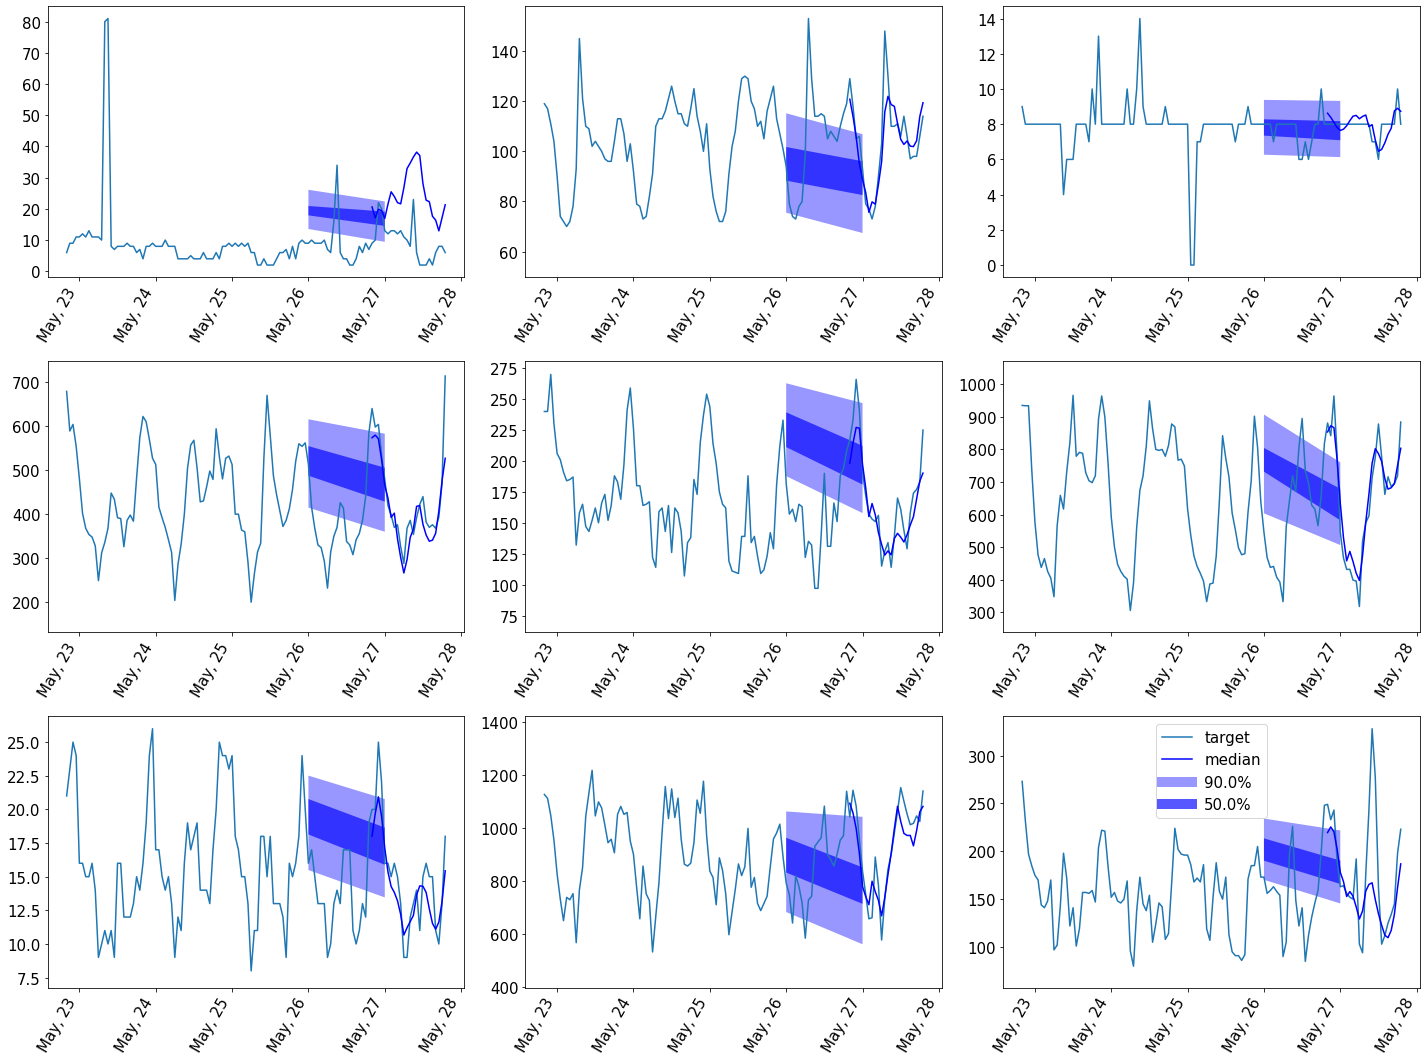

In [27]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx+1)
    ts = ts.copy()
    ts.index = ts.index.to_timestamp()

    plt.plot(ts[-5 * prediction_length:], label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    
plt.gcf().tight_layout()
plt.legend()
plt.show()

And we can compute evaluation metrics, that summarize the performance of the model on our test data.

In [28]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [29]:
metrics_pytorch, _ = evaluator(iter(tss_pytorch), iter(forecasts_pytorch), num_series=len(dataset.test))
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()

Running evaluation:   0%|                                                                          | 0/2247 [00:00<?, ?it/s]

Running evaluation: 100%|████████████████████████████████████████████████████████████| 2247/2247 [00:00<00:00, 22140.16it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]


/Users/stellalo/gluon-ts/src/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]


/Users/stellalo/gluon-ts/src/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]


/Users/stellalo/gluon-ts/src/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]


/Users/stellalo/gluon-ts/src/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]


/Users/stellalo/gluon-ts/src/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


,FeedForward
Coverage[0.1],6.380730e-02
Coverage[0.5],4.978861e-01
Coverage[0.9],9.207462e-01
MAE_Coverage,1.968427e-02
MAPE,1.494815e-01
MASE,9.570891e-01
MSE,2.694219e+06
MSIS,8.838813e+00
ND,8.676283e-02
NRMSE,6.881427e-01
